### Permutation Importance in the Presence of Correlated Features 

- This notebook adapts the sklearn "permutation importance in the presence of multi-colinearity" exercise, to a comparison of permutation importance feature attribution to SHAP.

 
    https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

### Library Import

In [175]:
print(__doc__)
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import shap
import pandas as pd 

import xgboost as xgb

Automatically created module for IPython interactive environment


### Data

In [176]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train = pd.DataFrame(X_train, columns = data.feature_names)
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
1,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,...,16.41,29.66,113.30,844.4,0.15740,0.3856,0.5106,0.20510,0.3585,0.11090
2,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,...,14.13,24.61,96.31,621.9,0.09329,0.2318,0.1604,0.06608,0.3207,0.07247
3,17.75,28.03,117.30,981.6,0.09997,0.13140,0.16980,0.08293,0.1713,0.05916,...,21.53,38.54,145.40,1437.0,0.14010,0.3762,0.6399,0.19700,0.2972,0.09075
4,20.58,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,0.05024,...,23.24,27.84,158.30,1656.0,0.11780,0.2920,0.3861,0.19200,0.2909,0.05865


### Model

In [178]:

n_features = np.arange(30)
n_features = n_features[2:len(n_features)]

model_params = {
    'n_estimators': [1, 2, 3]
   # 'max_features': [1],
   # 'min_samples_split': [2, 4, 6, 12, 24],
    #'max_depth': [1,2,3]}
}


rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
#xgb_model.fit(X, y)


# set up grid search meta-estimator
clf = GridSearchCV(rf, model_params, cv=3, n_jobs=-1)

clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.93


In [179]:
clf = clf.best_estimator_

clf

RandomForestClassifier(class_weight='balanced', n_estimators=3, n_jobs=-1,
                       random_state=42)

### Estimator 1 

In [ ]:
from sklearn.tree import export_graphviz# Export as dot file


export_graphviz(clf.estimators_[0], 
                out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [182]:

importances = pd.DataFrame(clf.estimators_[0].feature_importances_.reshape(1,30), columns =  X_train.columns).T
importances.columns = ['weight']

importances[importances['weight'] >0].sort_values(by='weight', ascending=False)

#['mean radius' 'mean perimeter' 'mean area' 'worst radius'
 #'worst perimeter' 'worst area']

#worst area
#

,weight
worst concave points,7.789954e-01
worst area,6.949014e-02
radius error,5.336198e-02
worst fractal dimension,3.562742e-02
mean concave points,3.506273e-02
mean radius,1.157721e-02
mean texture,6.932425e-03
symmetry error,4.728556e-03
mean symmetry,4.224176e-03
mean concavity,3.204386e-16


### Estimator 2

In [ ]:
from sklearn.tree import export_graphviz# Export as dot file


export_graphviz(clf.estimators_[1], 
                out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [184]:

importances = pd.DataFrame(clf.estimators_[1].feature_importances_.reshape(1,30), columns =  X_train.columns).T
importances.columns = ['weight']

importances[importances['weight'] >0].sort_values(by='weight', ascending=False)

,weight
worst concavity,5.335308e-01
mean perimeter,1.357164e-01
worst perimeter,7.530304e-02
worst texture,6.819186e-02
mean smoothness,5.498754e-02
worst radius,5.108615e-02
concavity error,3.063903e-02
worst fractal dimension,2.259839e-02
radius error,2.043725e-02
mean radius,7.037832e-03


### Estimator 3

In [ ]:
from sklearn.tree import export_graphviz# Export as dot file


export_graphviz(clf.estimators_[2], 
                out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [155]:

importances = pd.DataFrame(clf.estimators_[2].feature_importances_.reshape(1,30), columns =  X_train.columns).T
importances.columns = ['weight']

importances[importances['weight'] >0].sort_values(by='weight', ascending=False)

,weight
worst concave points,6.210009e-01
mean concave points,1.057053e-01
mean area,6.547401e-02
worst symmetry,3.998043e-02
mean fractal dimension,2.964875e-02
worst texture,2.800346e-02
texture error,1.766043e-02
radius error,1.462863e-02
worst concavity,1.439292e-02
mean concavity,1.404990e-02


### Feature Importance 1)
###  Random Forest Feature Importance (MDI) vs Permutation Importance

Next, we plot the tree based feature importance and the permutation importance. The permutation importance plot shows that permuting a feature <b>drops the accuracy by at most 0.012, which would suggest that none of the features are important. </b>This is in contradiction with the high test accuracy computed above: some feature must be important. The permutation importance is calculated on the training set to show how much the model relies on each feature during training.

FixedFormatter should only be used together with FixedLocator


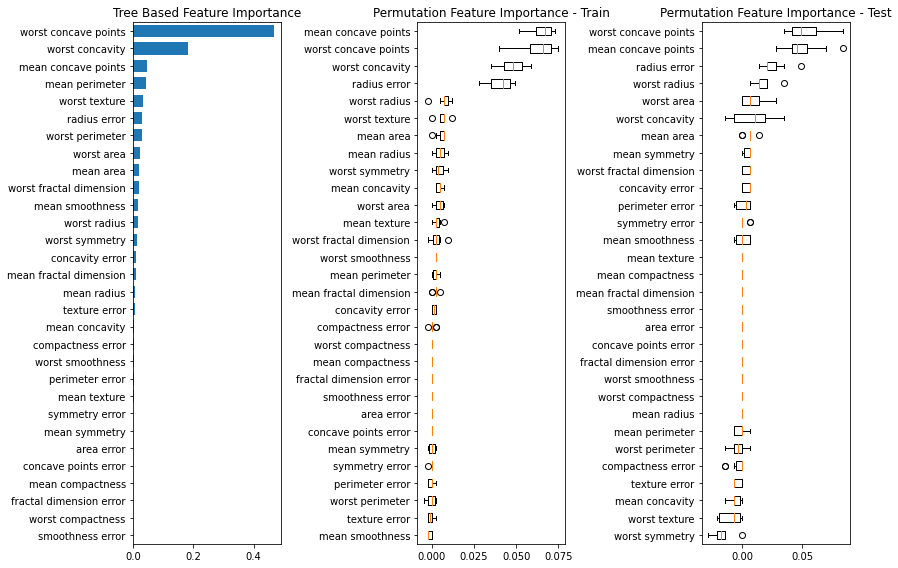

In [156]:




tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax1.title.set_text('Tree Based Feature Importance')

result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()


ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
ax2.title.set_text('Permutation Feature Importance - Train')

result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()


ax3.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
ax3.title.set_text('Permutation Feature Importance - Test')

fig.tight_layout()
plt.show()

### "Handling" Multicollinear Features

#### Visualize Feature Correlation
##### Dendogram heatmap

### The idea is ... you can build a model that's equivalent randomly choosing any of these variables. 

In [158]:
X_train = np.array(X_train)

cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
for v in cluster_id_to_feature_ids.values():
    print(data.feature_names[v])
    print(' ')
    print(data.feature_names[v[0]], "selected feature name")
    print('------------------------')
    print(' ')
        

print('Selected features takens arbitrarily the 1st feature in the cluster list')
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

['mean radius' 'mean perimeter' 'mean area' 'worst radius'
 'worst perimeter' 'worst area']
 
mean radius selected feature name
------------------------
 
['mean texture' 'worst texture']
 
mean texture selected feature name
------------------------
 
['mean smoothness' 'worst smoothness']
 
mean smoothness selected feature name
------------------------
 
['mean compactness' 'worst compactness' 'worst concavity']
 
mean compactness selected feature name
------------------------
 
['mean concavity' 'mean concave points' 'worst concave points']
 
mean concavity selected feature name
------------------------
 
['mean symmetry' 'worst symmetry']
 
mean symmetry selected feature name
------------------------
 
['mean fractal dimension']
 
mean fractal dimension selected feature name
------------------------
 
['radius error' 'perimeter error' 'area error']
 
radius error selected feature name
------------------------
 
['texture error']
 
texture error selected feature name
----------------

In [ ]:
X_train = np.array(X_train)

cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
for v in cluster_id_to_feature_ids.values():
    print(data.feature_names[v])
    print(' ')
    print(data.feature_names[v[0]], "selected feature name")
    print('------------------------')
    print(' ')
        

print('Selected features takens arbitrarily the 1st feature in the cluster list')
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [ ]:

print('Selected features takens arbitrarily the 1st feature in the cluster list')
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

X_train_sel = pd.DataFrame(X_train_sel, columns=data.feature_names[selected_features])

X_train_sel.head()

### Refit Model with Reduced Features

In [160]:
###
clf_sel =RandomForestClassifier(class_weight='balanced', n_estimators=3, n_jobs=-1,
                       random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.94


In [ ]:
from sklearn.tree import export_graphviz# Export as dot file


export_graphviz(clf_sel.estimators_[0], 
                out_file='tree.dot', 
                feature_names = X_train_sel.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:

importances = pd.DataFrame(clf_sel.estimators_[0].feature_importances_.reshape(1,X_train_sel.shape[1]), columns =  X_train_sel.columns).T
importances.columns = ['weight']

importances[importances['weight'] >0].sort_values(by='weight', ascending=False)

In [ ]:
from sklearn.tree import export_graphviz# Export as dot file


export_graphviz(clf_sel.estimators_[1], 
                out_file='tree.dot', 
                feature_names = X_train_sel.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:

importances = pd.DataFrame(clf_sel.estimators_[1].feature_importances_.reshape(1,X_train_sel.shape[1]), columns =  X_train_sel.columns).T
importances.columns = ['weight']

importances[importances['weight'] >0].sort_values(by='weight', ascending=False)

In [ ]:
from sklearn.tree import export_graphviz# Export as dot file


export_graphviz(clf_sel.estimators_[2], 
                out_file='tree.dot', 
                feature_names = X_train_sel.columns,
                class_names = ['0','1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:

importances = pd.DataFrame(clf_sel.estimators_[2].feature_importances_.reshape(1,X_train_sel.shape[1]), columns =  X_train_sel.columns).T
importances.columns = ['weight']

importances[importances['weight'] >0].sort_values(by='weight', ascending=False)

In [ ]:
clf = clf_sel

result = permutation_importance(clf, X_train_sel, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

#### Visualize Feature Correlation - Cluster Selected Features
##### Dendogram heatmap

In [ ]:
import seaborn as sns

g = sns.clustermap(X_train_sel.corr())